In [ ]:
from google.colab import files
uploaded = files.upload()

Saving anomalyfreereturns.csv to anomalyfreereturns (3).csv


In [ ]:
import io
import pandas as pd
returnsant = pd.read_csv(io.BytesIO(uploaded['anomalyfreereturns.csv']))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(returnsant.drop("Hedge Fund",axis=1),returnsant["Hedge Fund"])

In [ ]:
import numpy as np
print(y_train)
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)


31    -0.0049
28     0.0095
37     0.0672
4     -0.0325
23     0.0302
        ...  
130   -0.0137
25     0.0189
36     0.0550
15     0.0250
110    0.0033
Name: Hedge Fund, Length: 146, dtype: float64


In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
y_train=np.array(y_train).reshape(-1,1)
y_test=np.array(y_test)
fit=sc.fit(y_train)

In [ ]:
y_train=sc.transform(y_train)


In [ ]:
print(y_train.shape)

(146, 1)


In [ ]:
y_train=y_train.reshape(1,-1)

In [ ]:
y_test=y_test.values.reshape(-1,1)

In [ ]:
y_test=np.array(y_test).reshape(-1,1)
y_test=sc.transform(y_test)

In [ ]:
y_test=y_test.reshape(1,-1)

In [ ]:
    
SEQUENCE_SIZE = 8

x_train,ynew_train = to_sequences(SEQUENCE_SIZE,y_train)
x_test,ynew_test = to_sequences(SEQUENCE_SIZE,y_test)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (138, 8, 1, 1)
Shape of test set: (41, 8, 1, 1)


In [ ]:
x_train.shape = (138,8,1)

In [ ]:
x_test.shape = ( 41, 8, 1)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs,head_size, num_heads,ff_dim,dropout=0):
    x=layers.LayerNormalization(epsilon=1e-6)(inputs)
    x=layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x,x)
    x=layers.Dropout(dropout)(x)
    res=x+inputs
    
    x= layers.LayerNormalization(epsilon=1e-6)(res)
    x=layers.Conv1D(filters=ff_dim,kernel_size=1, activation='relu')(x)
    x=layers.Dropout(dropout)(x)
    x=layers.Conv1D(filters=inputs.shape[-1],kernel_size=1)(x)
    return x + res

In [ ]:
def transformer_model(input_shape, head_size, num_heads, ff_dim,num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs=keras.Input(shape=input_shape)
    x=inputs
    for _ in range(num_transformer_blocks):
        x=transformer_encoder( x,head_size, num_heads,ff_dim, dropout)
    x=layers.GlobalAveragePooling1D(data_format='channels_first')(x)
    for dim in mlp_units:
        x=layers.Dense(dim, activation='relu')(x)
        x=layers.Dropout(mlp_dropout)(x)
    outputs=layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [ ]:
from sklearn.preprocessing import StandardScaler

input_shape = x_train.shape[1:]


model = transformer_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model.fit(
    x_train,
    ynew_train,
    validation_split=0.2,
    epochs=60,
    batch_size=10,
    callbacks=callbacks,
)

model.evaluate(x_test, ynew_test, verbose=1)

Epoch 1/60
11/11 [==============================] - 3s 58ms/step - loss: 1.2577 - val_loss: 0.8876
Epoch 2/60
11/11 [==============================] - 0s 21ms/step - loss: 1.2914 - val_loss: 0.8764
Epoch 3/60
11/11 [==============================] - 0s 22ms/step - loss: 1.2701 - val_loss: 0.8671
Epoch 4/60
11/11 [==============================] - 0s 22ms/step - loss: 1.1665 - val_loss: 0.8576
Epoch 5/60
11/11 [==============================] - 0s 22ms/step - loss: 1.2894 - val_loss: 0.8522
Epoch 6/60
11/11 [==============================] - 0s 27ms/step - loss: 1.2118 - val_loss: 0.8488
Epoch 7/60
11/11 [==============================] - 0s 22ms/step - loss: 1.1297 - val_loss: 0.8462
Epoch 8/60
11/11 [==============================] - 0s 23ms/step - loss: 1.2699 - val_loss: 0.8435
Epoch 9/60
11/11 [==============================] - 0s 22ms/step - loss: 1.1157 - val_loss: 0.8417
Epoch 10/60
11/11 [==============================] - 0s 21ms/step - loss: 1.1457 - val_loss: 0.8374
Epoch 11/

1.6504762172698975

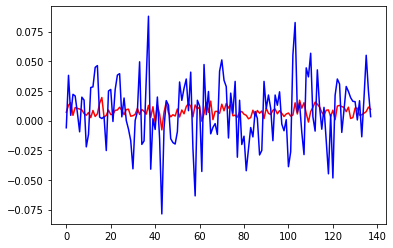

In [ ]:
import matplotlib.pyplot as plt
predict=model.predict(x_train)
plt.figure()
plt.plot(np.arange(len(predict)),sc.inverse_transform(predict),c='r')
plt.plot(np.arange(len(predict)),sc.inverse_transform(ynew_train),c='b')